In [6]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Navier-Stokes equation discussed in Section 5.3 in the [paper](https://arxiv.org/pdf/2010.08895.pdf),
which uses a recurrent structure to propagates in time.
"""

import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['export OPENBLAS_NUM_THREADS']='2'

import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)

In [7]:

################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

# Splits training samples in batches of e.g.20 so if 1000 training samples then 50 batches of 20 training samples
batch_size = 20
learning_rate = 0.001

epochs =  500
step_size = 50
gamma = 0.5

modes = 16
width = 64


################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
dataloader = MatReader('data/burgers_data_R10.mat')

# Size: 2048 x 1024 (total columns are 8192 but subsampling rate = 8, columns = 8192/8=1024)
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

# Size: 1000 x 1024
x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]

# Size: 100 x 1024
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width).cuda()
# model = FNO1d(modes, width).cpu()
# print(count_params(model))

################################################################
# training and evaluation
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# hist_loss = []

myloss = LpLoss(size_average=False)
# for ep in range(epochs):
#     model.train()
#     t1 = default_timer()
#     train_mse = 0
#     train_l2 = 0
#     for x, y in train_loader:
#         # x, y = x.cuda(), y.cuda()
#         x, y = x.cpu(), y.cpu()

#         optimizer.zero_grad()
#         out = model(x)

#         mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
#         l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
#         l2.backward() # use the l2 relative loss

#         optimizer.step()
#         train_mse += mse.item()
#         train_l2 += l2.item()
    
#     scheduler.step()
#     model.eval()
#     test_l2 = 0.0
#     with torch.no_grad():
#         for x, y in test_loader:
#             # x, y = x.cuda(), y.cuda()
#             x, y = x.cpu(), y.cpu()

#             out = model(x)
#             test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

#     train_mse /= len(train_loader)
#     train_l2 /= ntrain
#     test_l2 /= ntest

#     # hist_loss.append(train_mse+train_l2)

#     t2 = default_timer()
#     print(ep, t2-t1, train_mse, train_l2, test_l2)

# y = np.linspace(1, epochs, epochs)
# a = plt.plot(hist_loss, y)
# plt.show()

# torch.save(model, 'model/ns_fourier_burgers')

torch.Size([1024, 1])
torch.Size([1024])


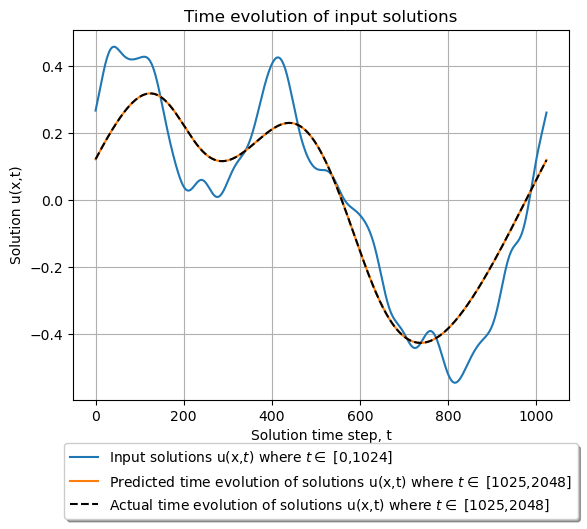

torch.Size([1024, 1])
torch.Size([1024])


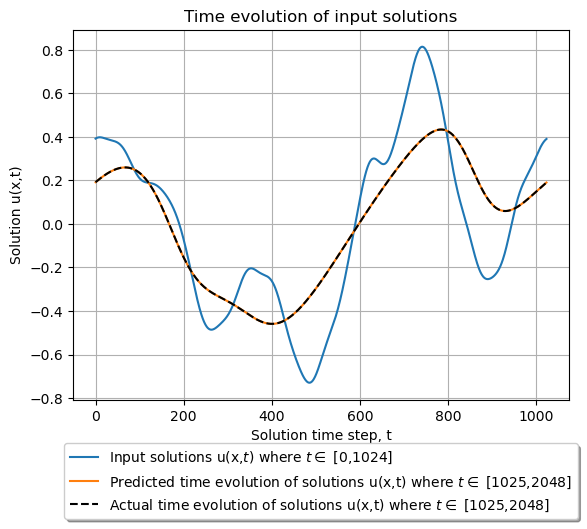

torch.Size([1024, 1])
torch.Size([1024])


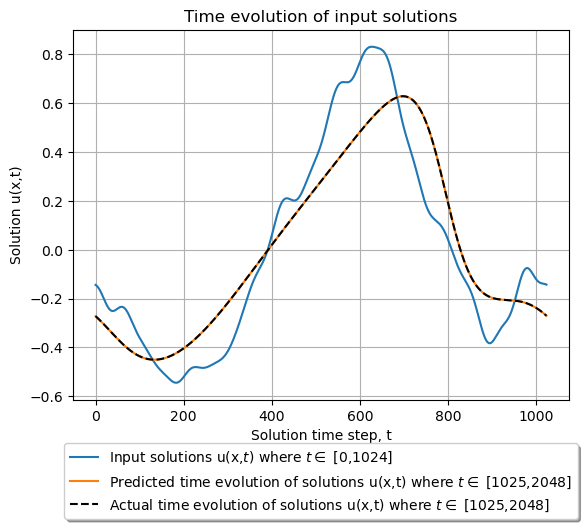

torch.Size([1024, 1])
torch.Size([1024])


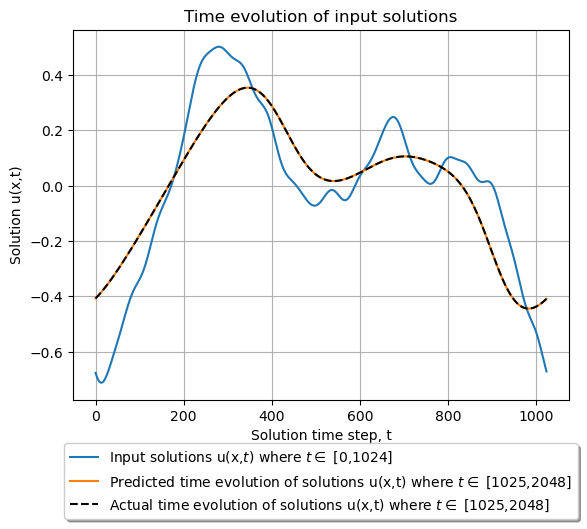

torch.Size([1024, 1])
torch.Size([1024])


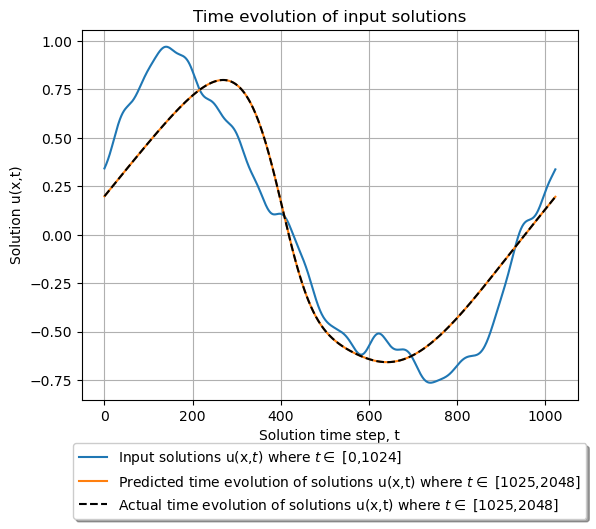

torch.Size([1024, 1])
torch.Size([1024])


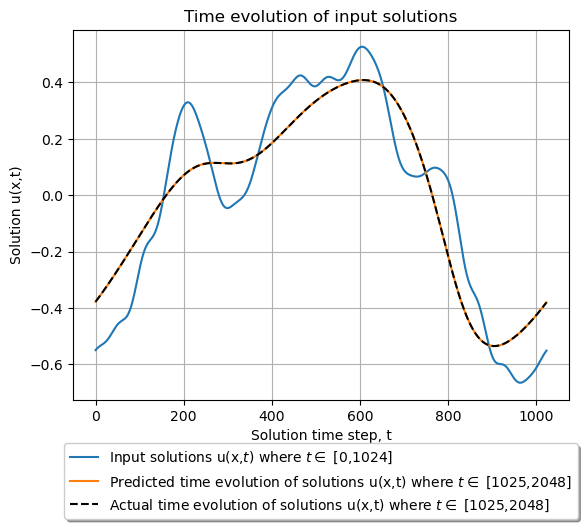

torch.Size([1024, 1])
torch.Size([1024])


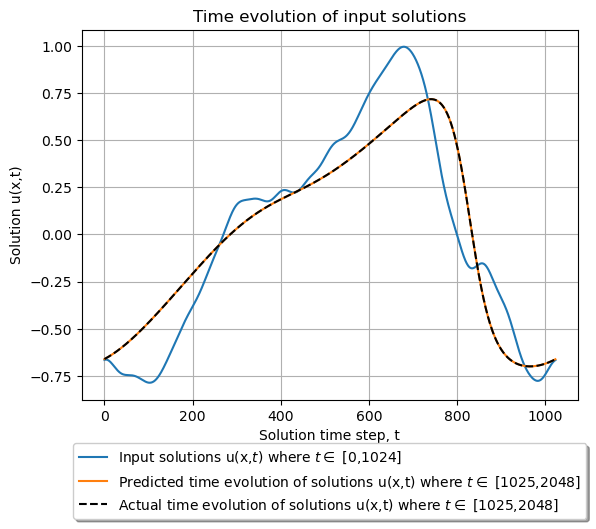

torch.Size([1024, 1])
torch.Size([1024])


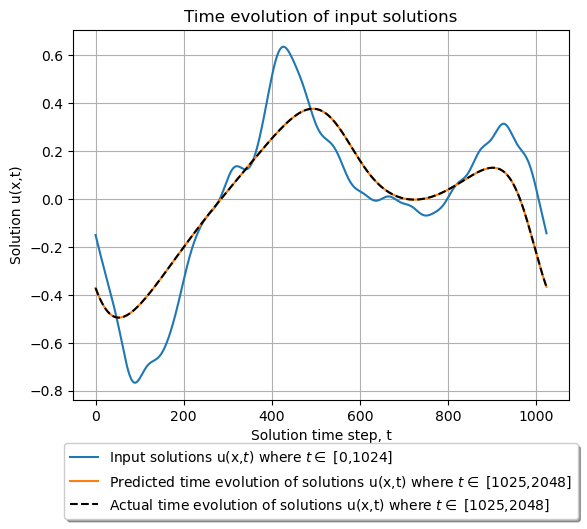

torch.Size([1024, 1])
torch.Size([1024])


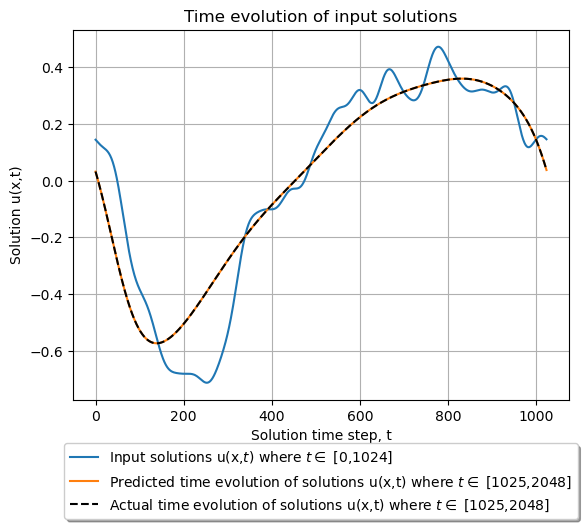

torch.Size([1024, 1])
torch.Size([1024])


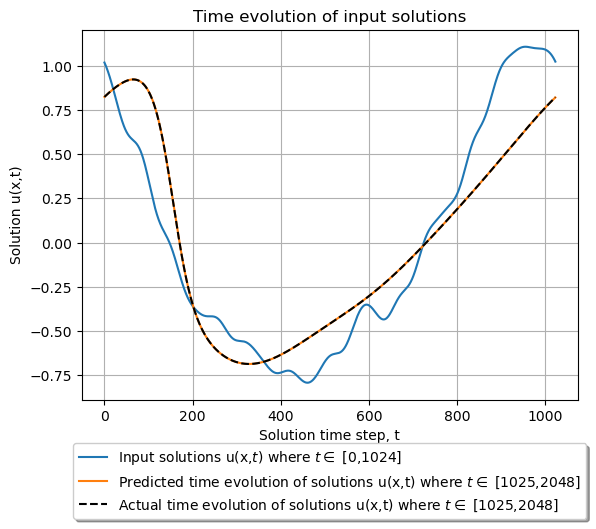

torch.Size([1024, 1])
torch.Size([1024])


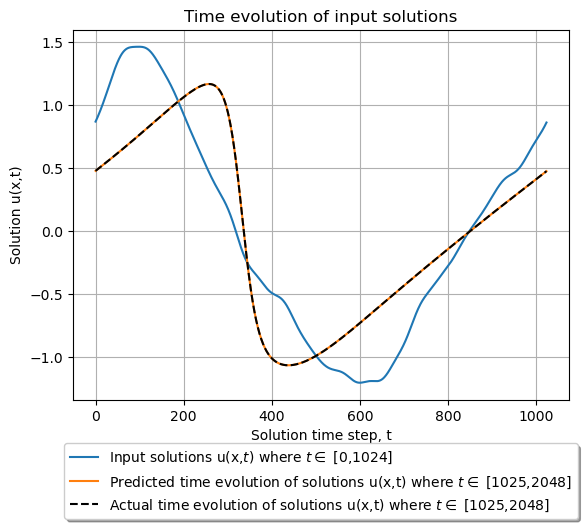

torch.Size([1024, 1])
torch.Size([1024])


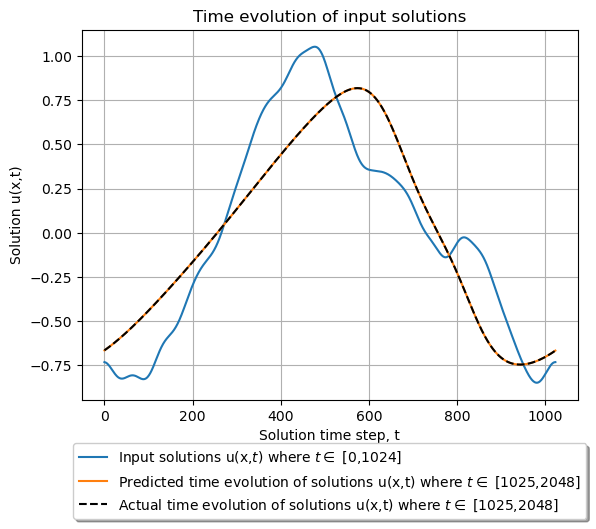

torch.Size([1024, 1])
torch.Size([1024])


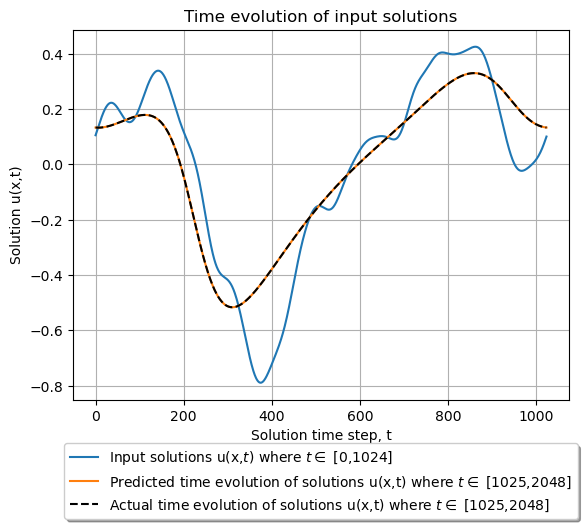

torch.Size([1024, 1])
torch.Size([1024])


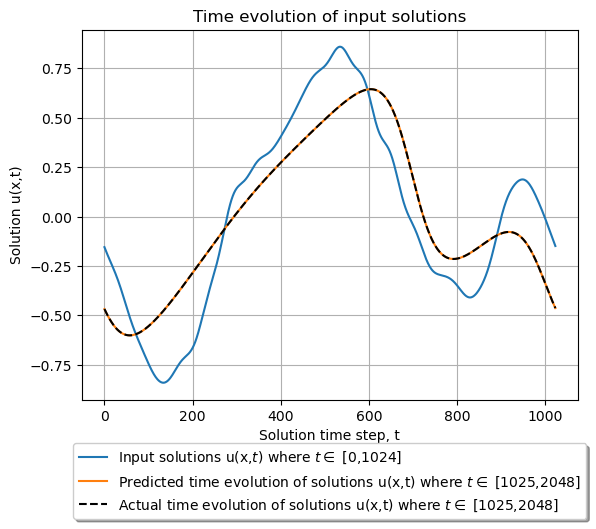

torch.Size([1024, 1])
torch.Size([1024])


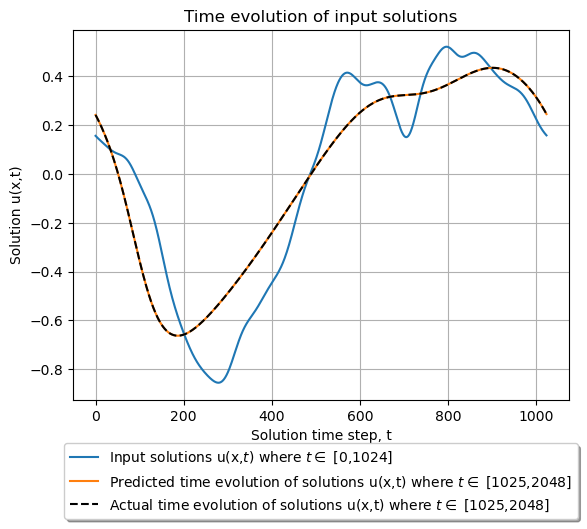

torch.Size([1024, 1])
torch.Size([1024])


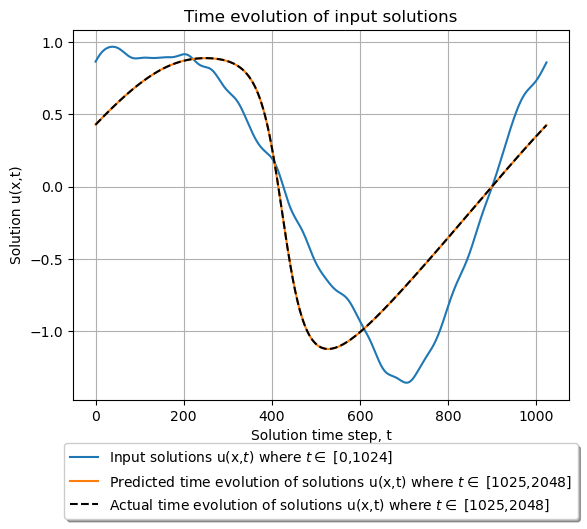

torch.Size([1024, 1])
torch.Size([1024])


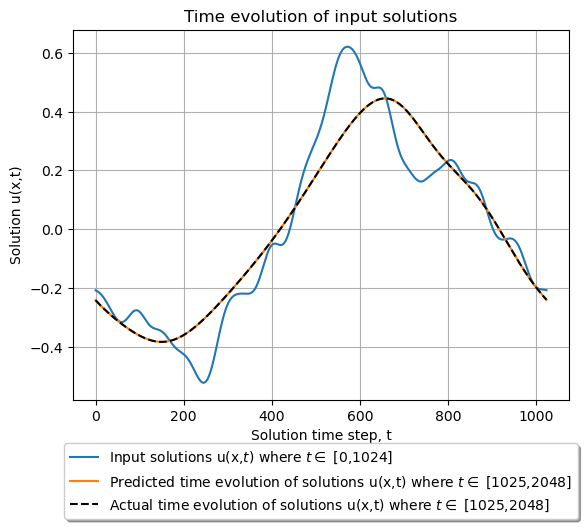

torch.Size([1024, 1])
torch.Size([1024])


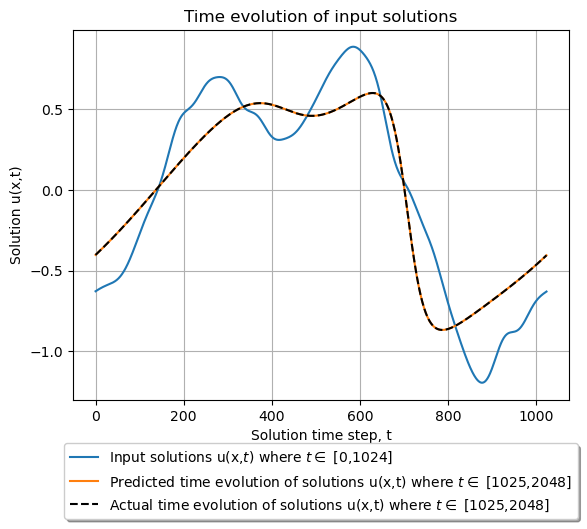

torch.Size([1024, 1])
torch.Size([1024])


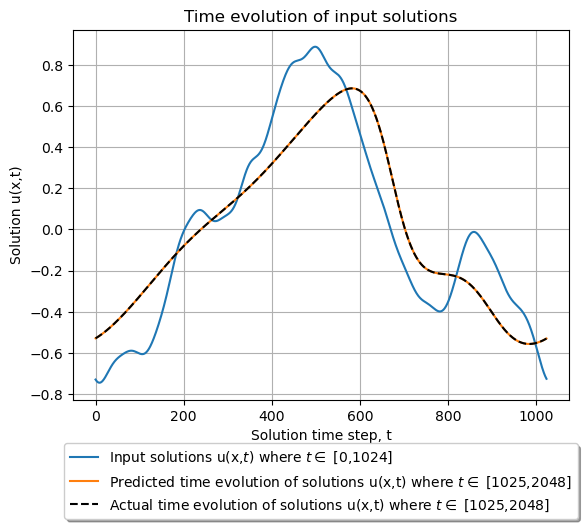

torch.Size([1024, 1])
torch.Size([1024])


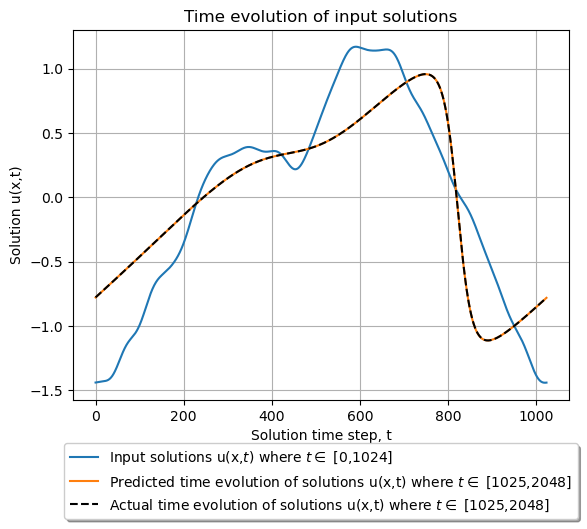

torch.Size([1024, 1])
torch.Size([1024])


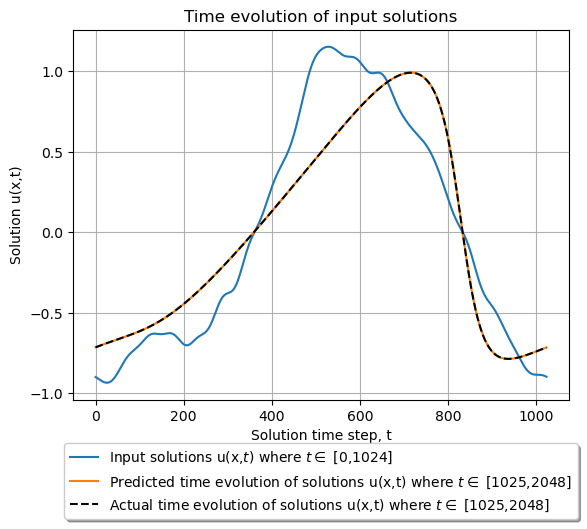

torch.Size([1024, 1])
torch.Size([1024])


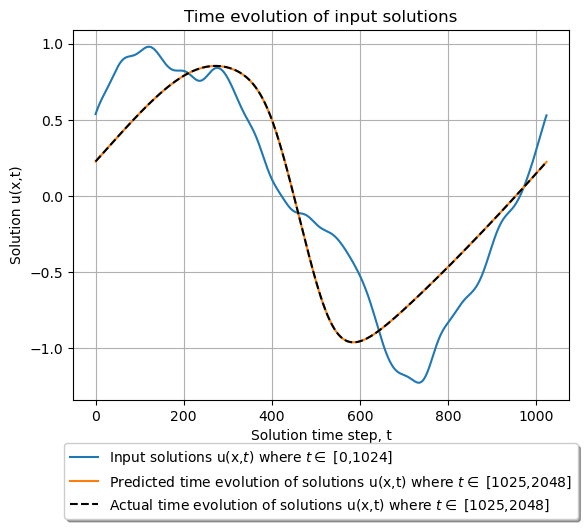

torch.Size([1024, 1])
torch.Size([1024])


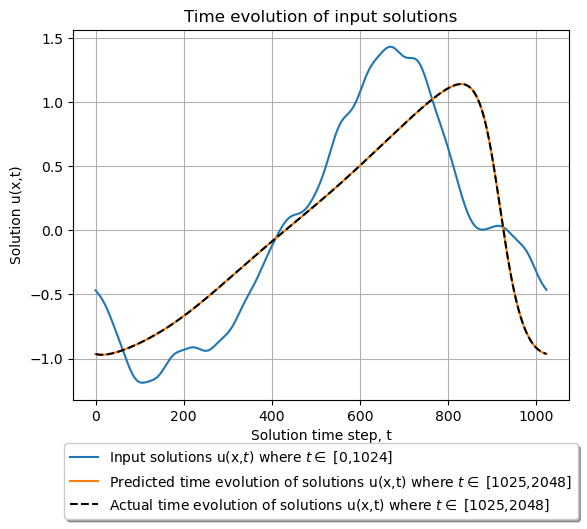

torch.Size([1024, 1])
torch.Size([1024])


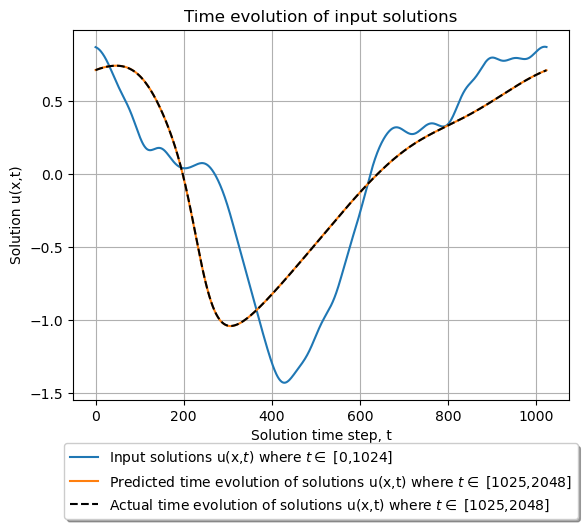

torch.Size([1024, 1])
torch.Size([1024])


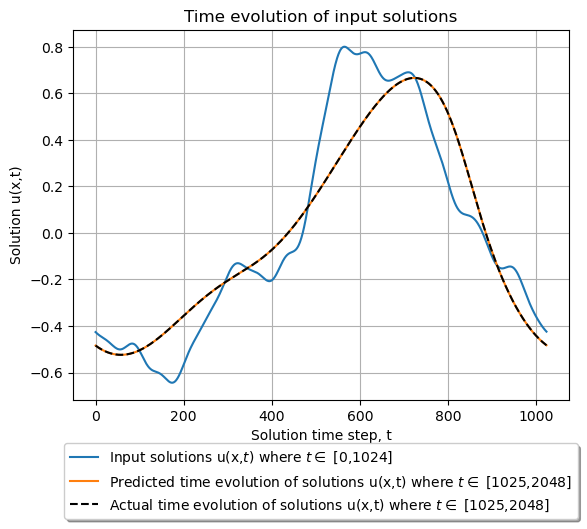

torch.Size([1024, 1])
torch.Size([1024])


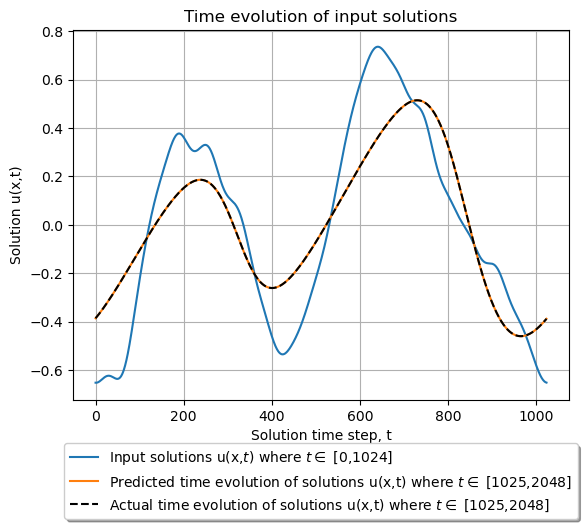

torch.Size([1024, 1])
torch.Size([1024])


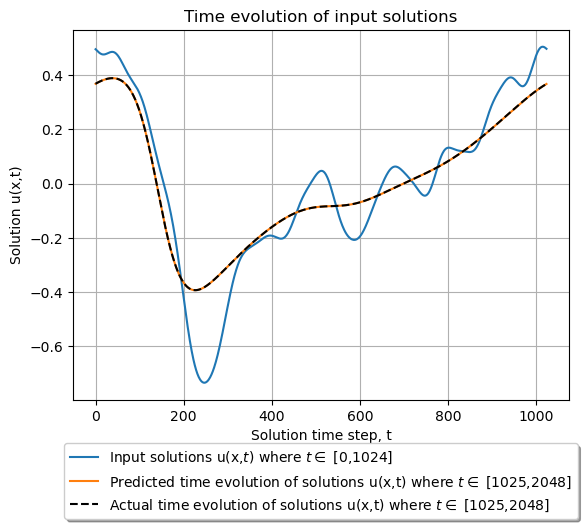

torch.Size([1024, 1])
torch.Size([1024])


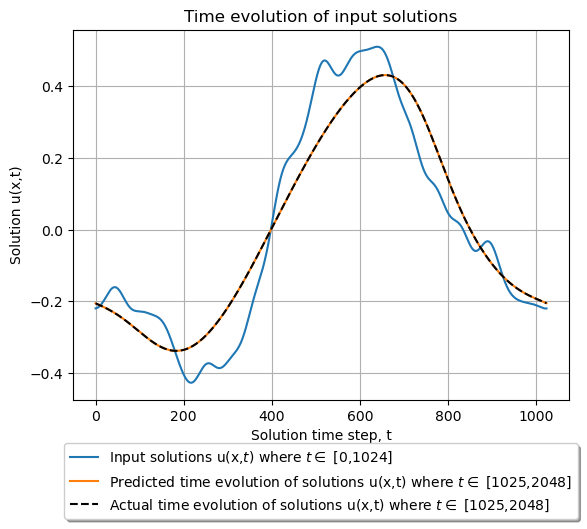

torch.Size([1024, 1])
torch.Size([1024])


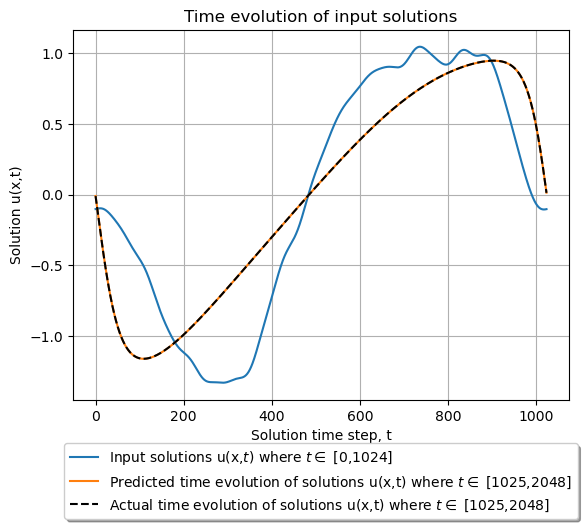

torch.Size([1024, 1])
torch.Size([1024])


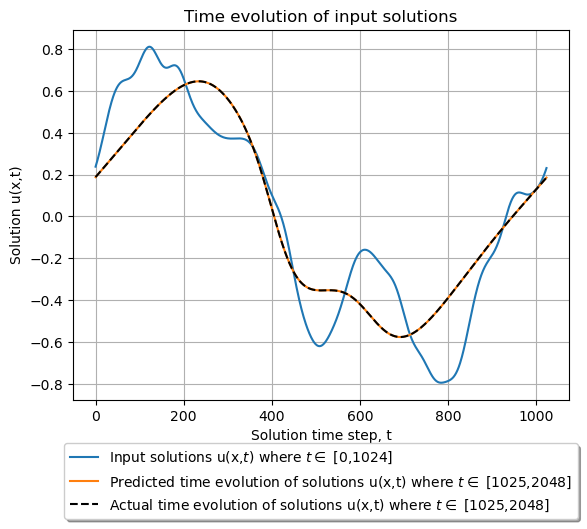

torch.Size([1024, 1])
torch.Size([1024])


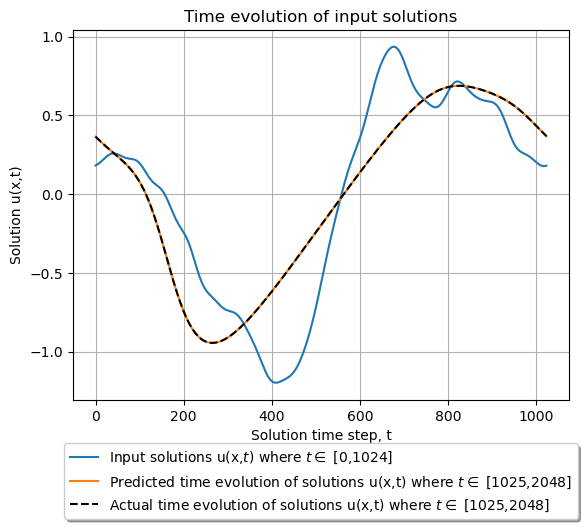

torch.Size([1024, 1])
torch.Size([1024])


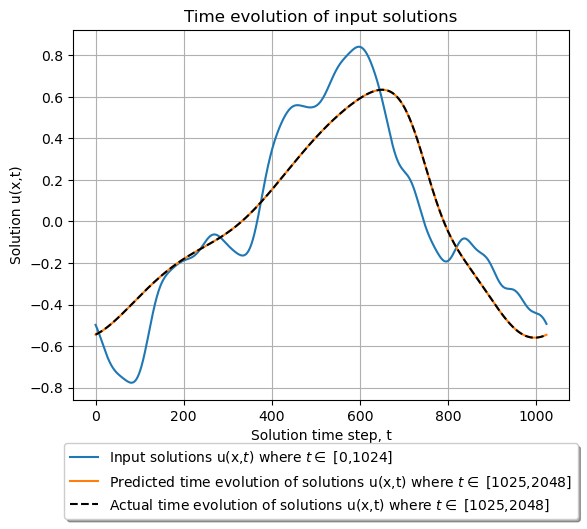

torch.Size([1024, 1])
torch.Size([1024])


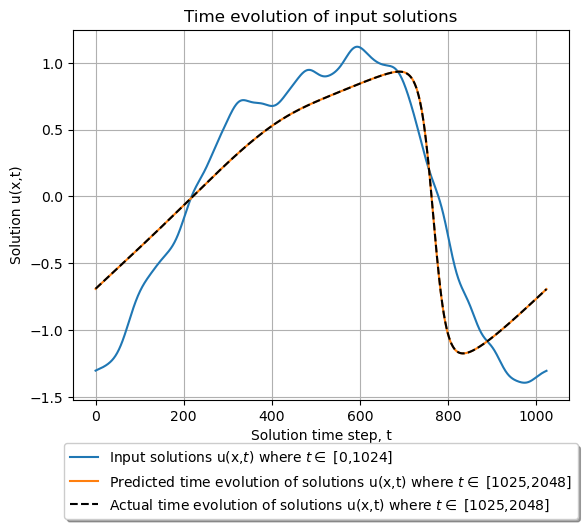

torch.Size([1024, 1])
torch.Size([1024])


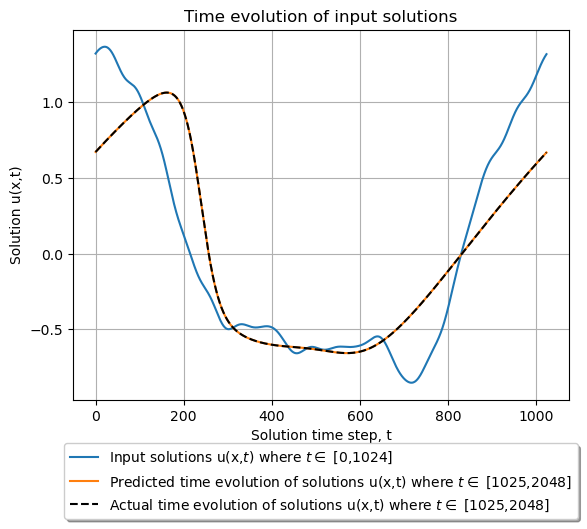

torch.Size([1024, 1])
torch.Size([1024])


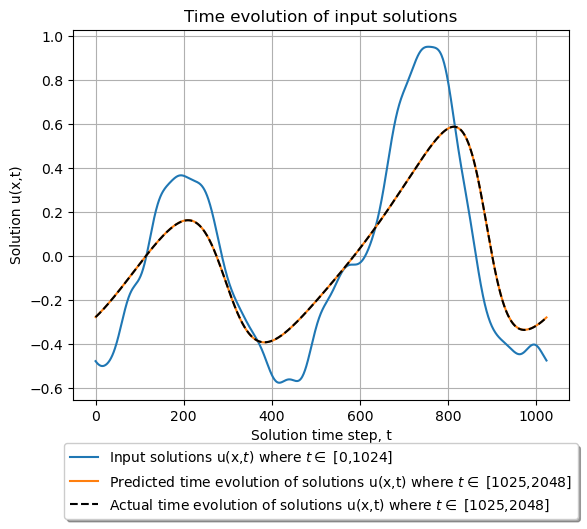

torch.Size([1024, 1])
torch.Size([1024])


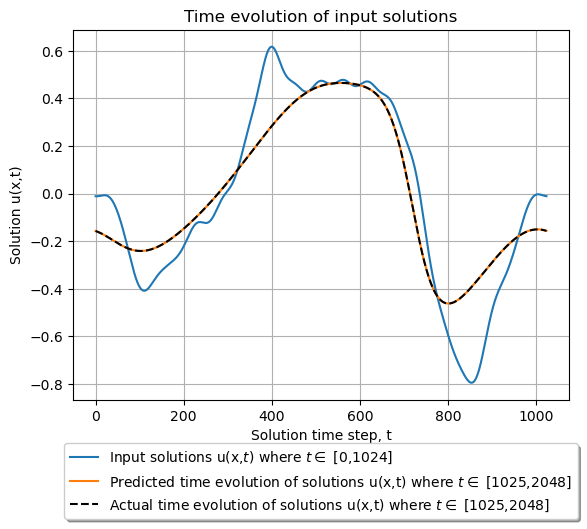

torch.Size([1024, 1])
torch.Size([1024])


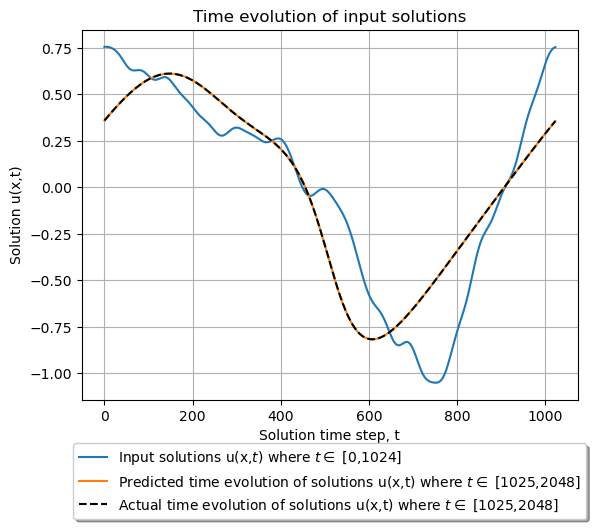

torch.Size([1024, 1])
torch.Size([1024])


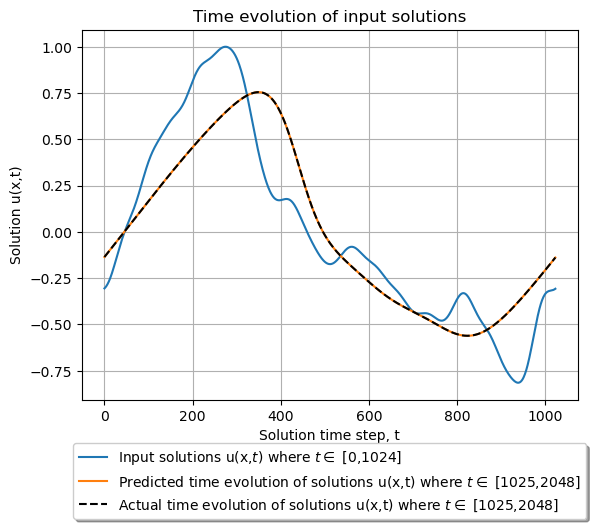

torch.Size([1024, 1])
torch.Size([1024])


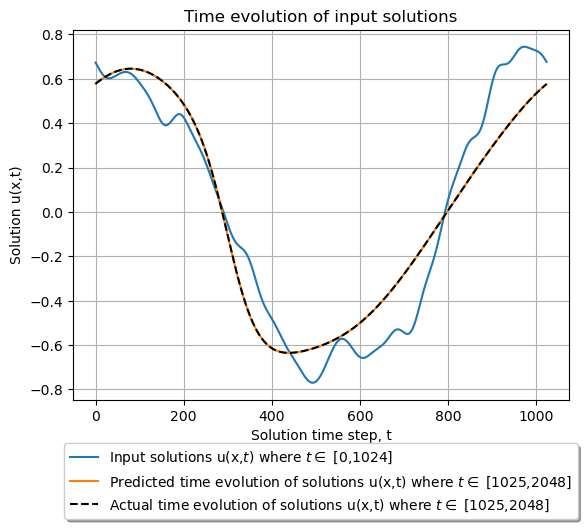

torch.Size([1024, 1])
torch.Size([1024])


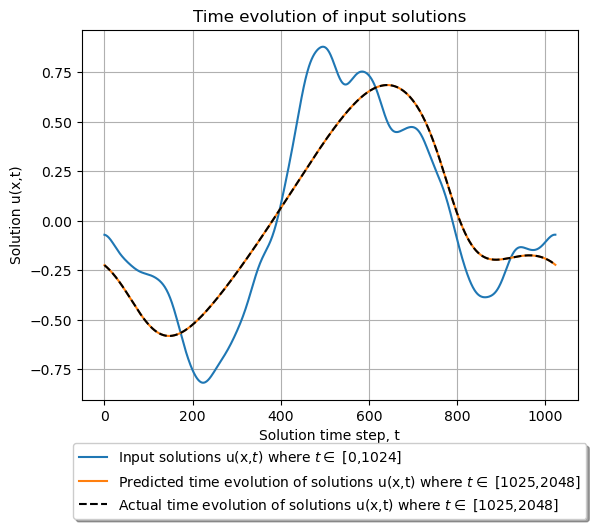

torch.Size([1024, 1])
torch.Size([1024])


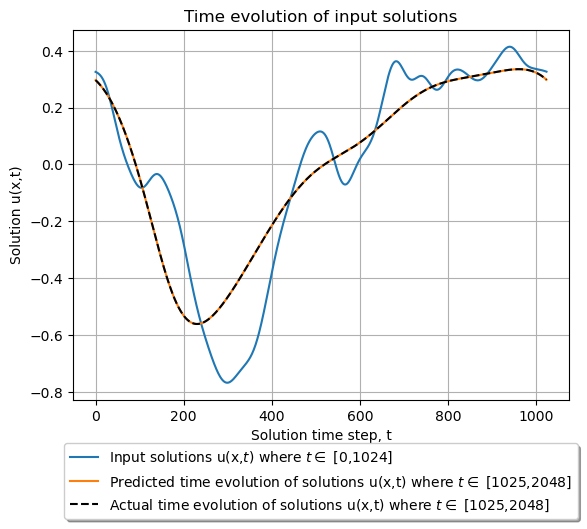

torch.Size([1024, 1])
torch.Size([1024])


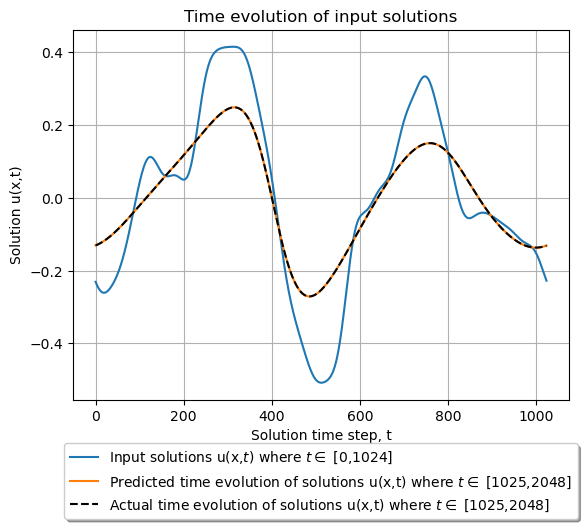

torch.Size([1024, 1])
torch.Size([1024])


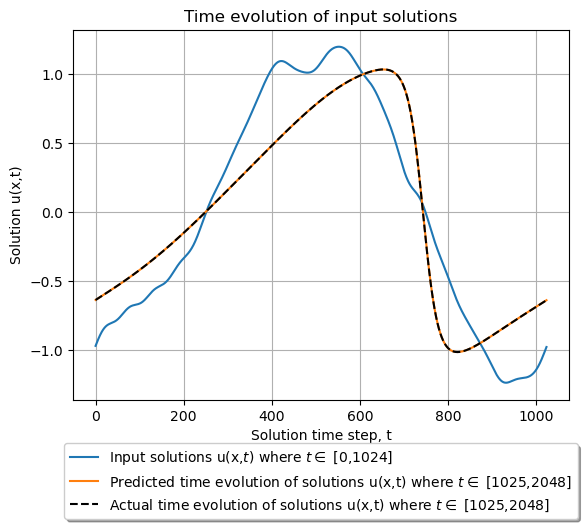

torch.Size([1024, 1])
torch.Size([1024])


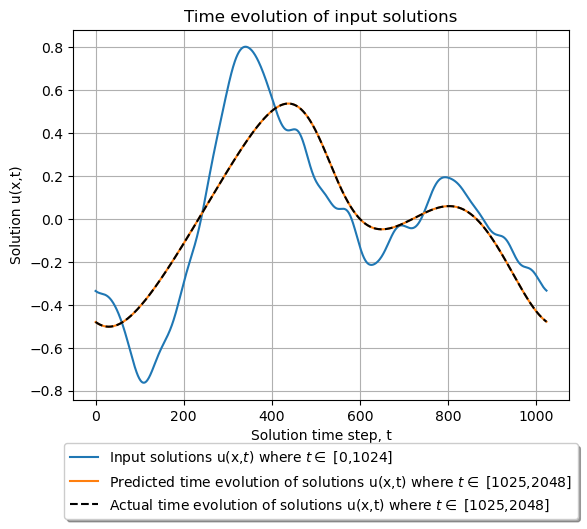

torch.Size([1024, 1])
torch.Size([1024])


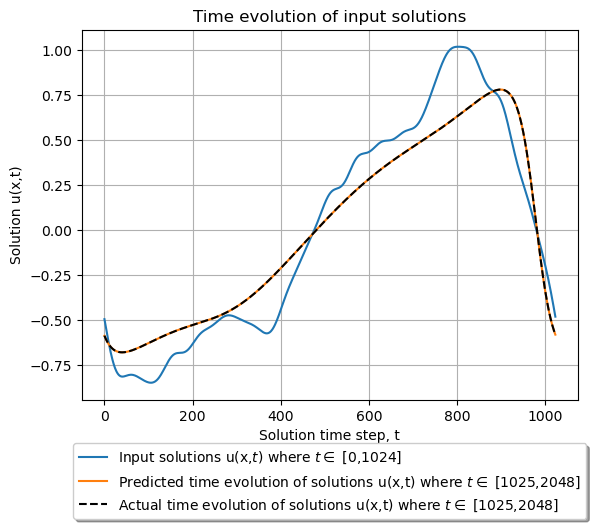

torch.Size([1024, 1])
torch.Size([1024])


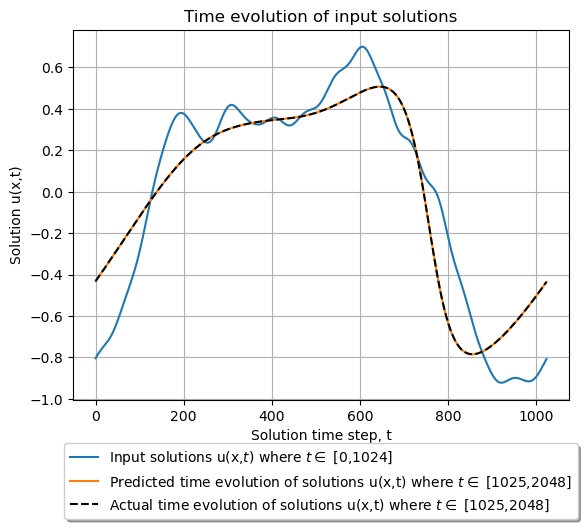

torch.Size([1024, 1])
torch.Size([1024])


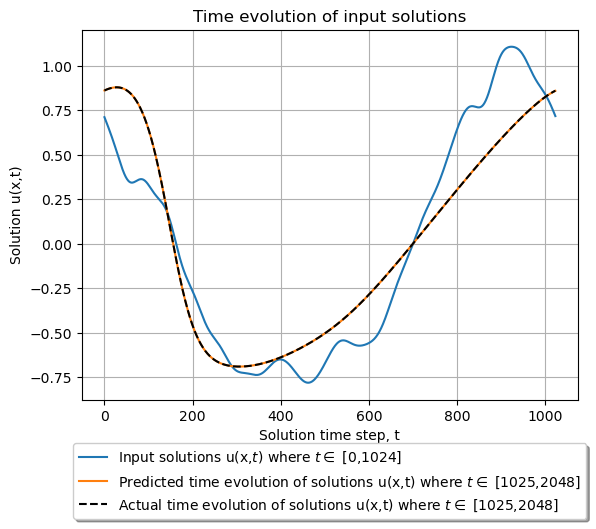

torch.Size([1024, 1])
torch.Size([1024])


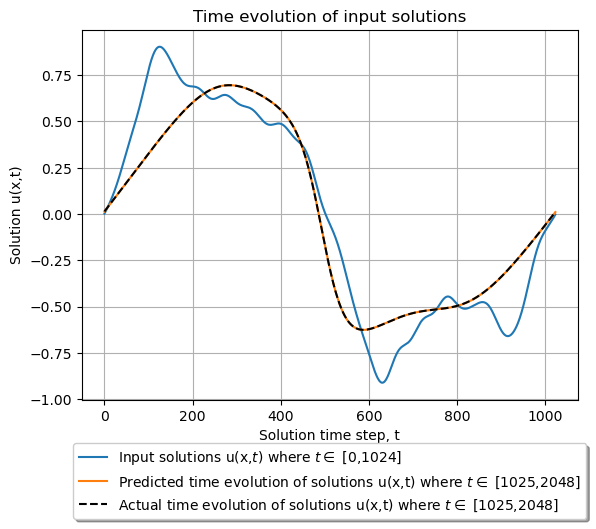

torch.Size([1024, 1])
torch.Size([1024])


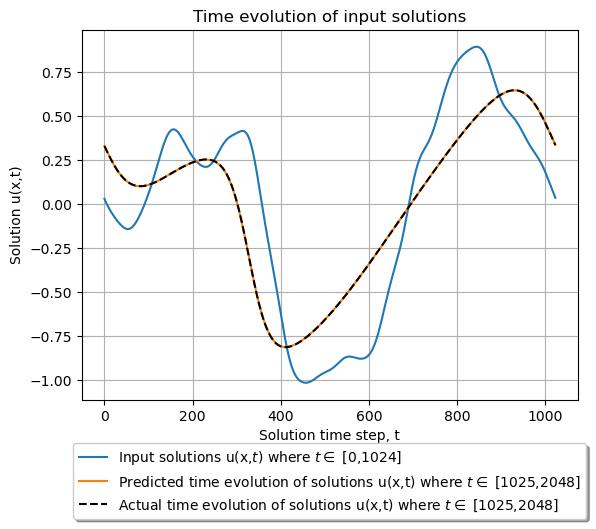

torch.Size([1024, 1])
torch.Size([1024])


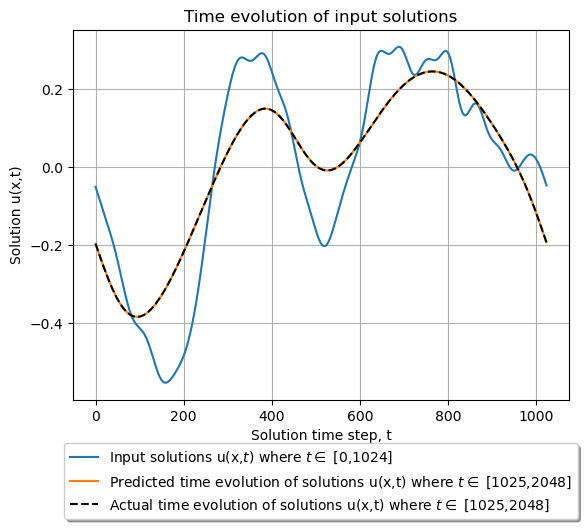

torch.Size([1024, 1])
torch.Size([1024])


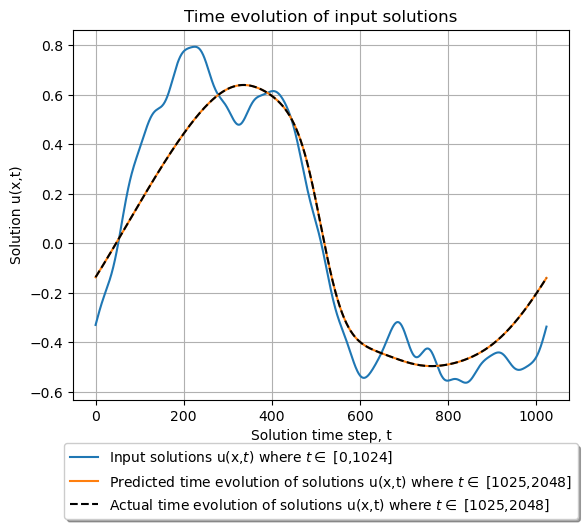

torch.Size([1024, 1])
torch.Size([1024])


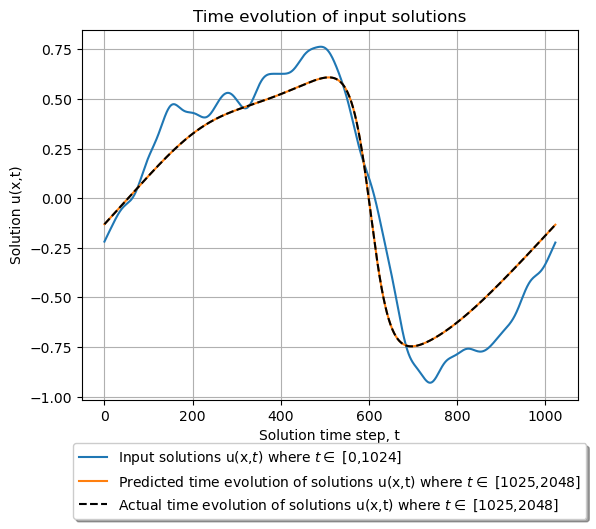

torch.Size([1024, 1])
torch.Size([1024])


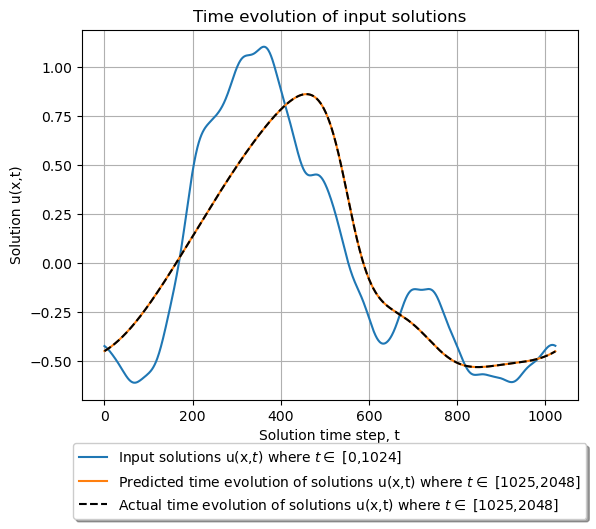

torch.Size([1024, 1])
torch.Size([1024])


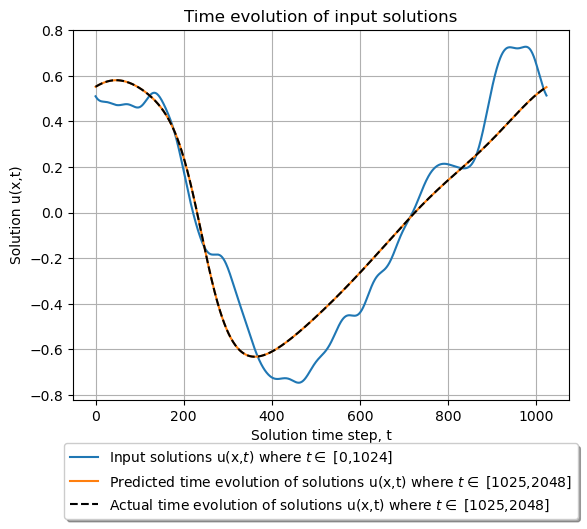

torch.Size([1024, 1])
torch.Size([1024])


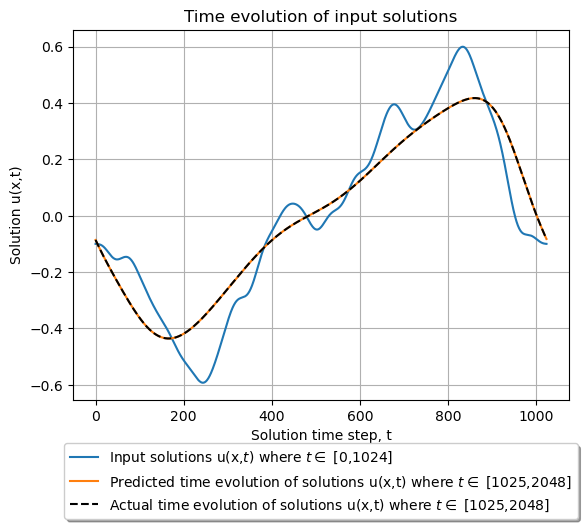

torch.Size([1024, 1])
torch.Size([1024])


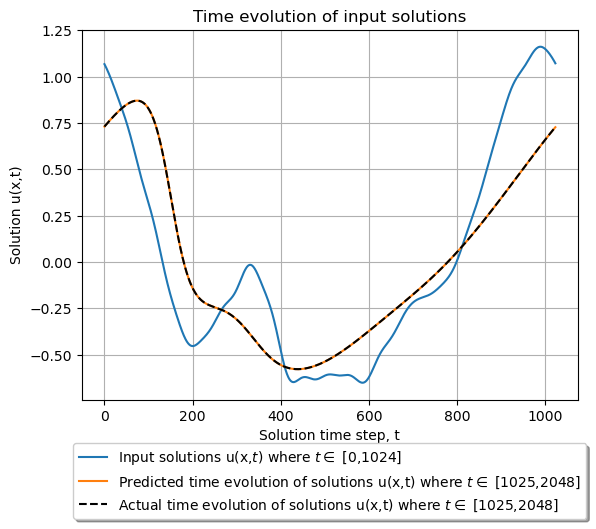

torch.Size([1024, 1])
torch.Size([1024])


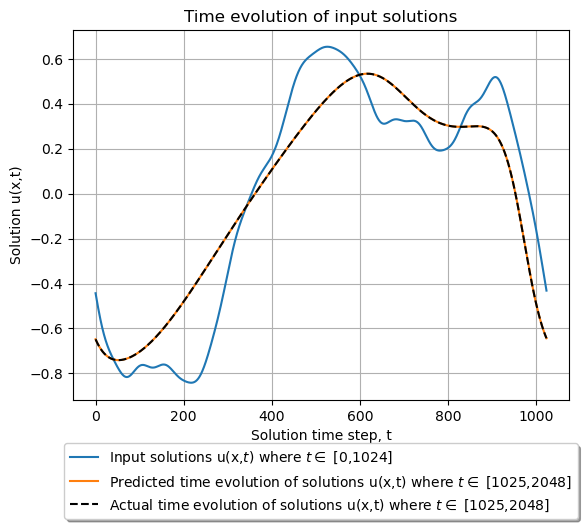

torch.Size([1024, 1])
torch.Size([1024])


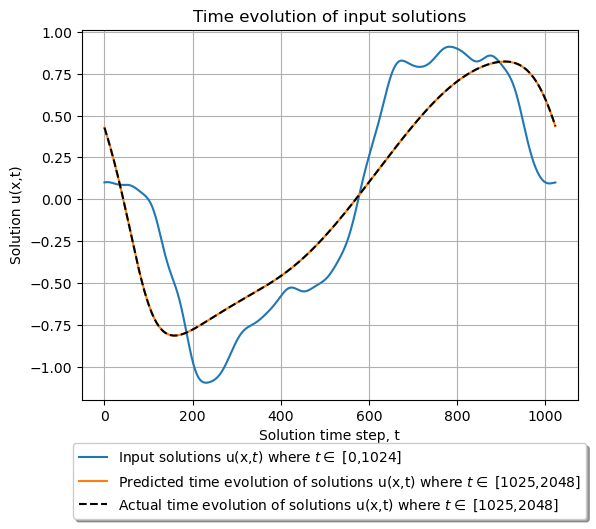

torch.Size([1024, 1])
torch.Size([1024])


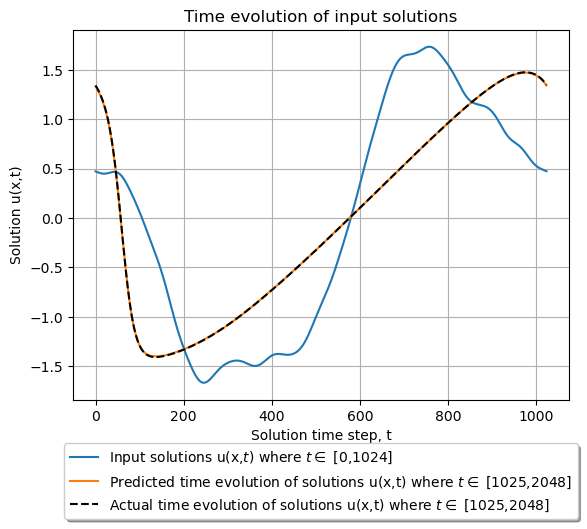

torch.Size([1024, 1])
torch.Size([1024])


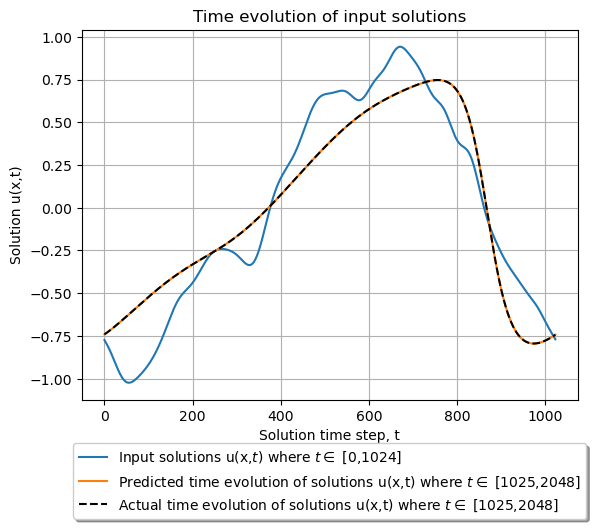

torch.Size([1024, 1])
torch.Size([1024])


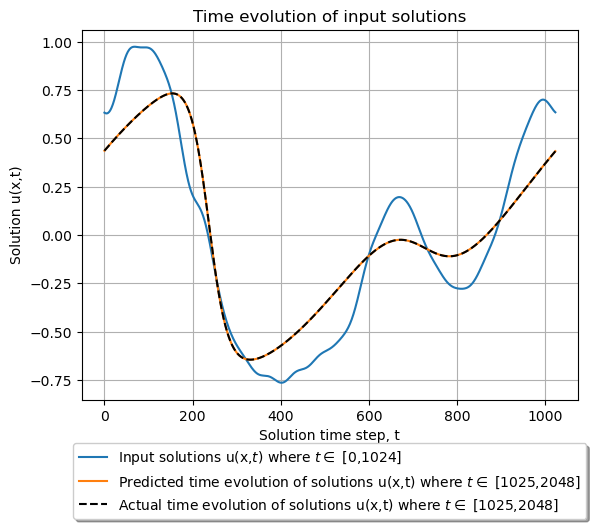

torch.Size([1024, 1])
torch.Size([1024])


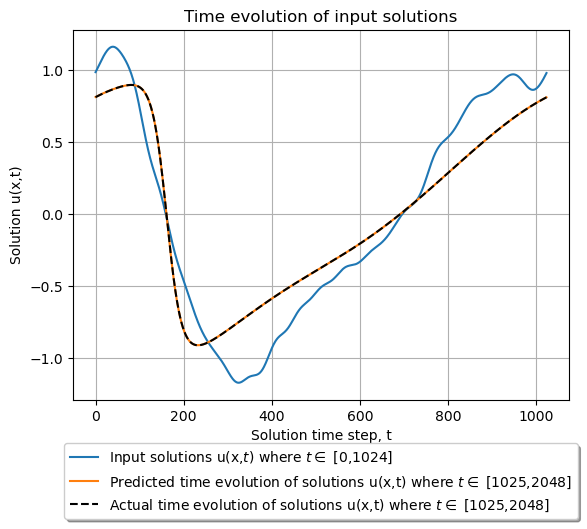

torch.Size([1024, 1])
torch.Size([1024])


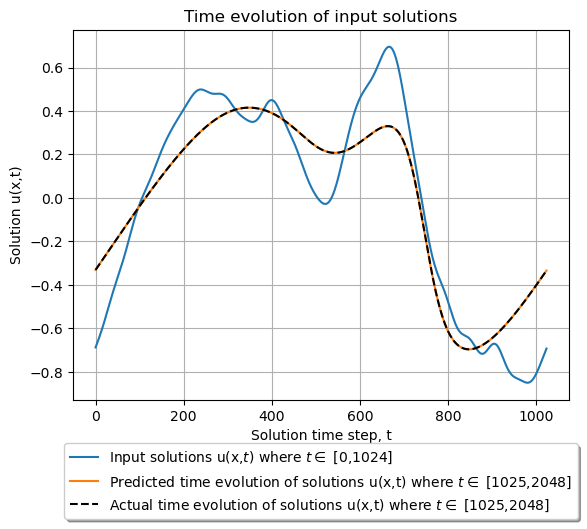

torch.Size([1024, 1])
torch.Size([1024])


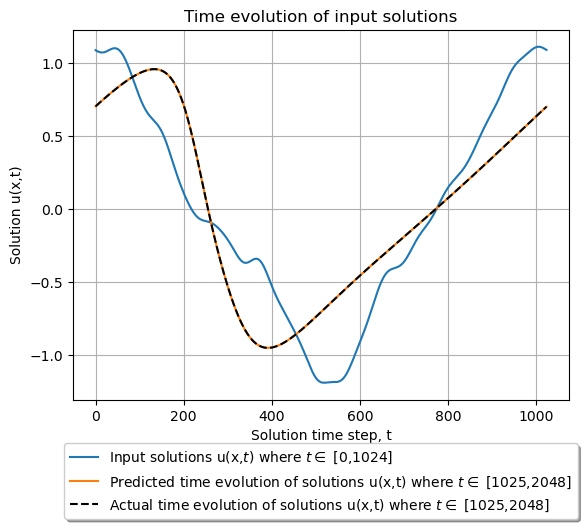

torch.Size([1024, 1])
torch.Size([1024])


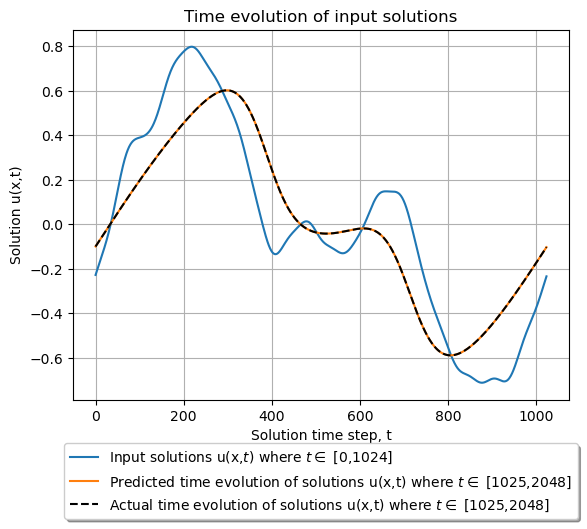

torch.Size([1024, 1])
torch.Size([1024])


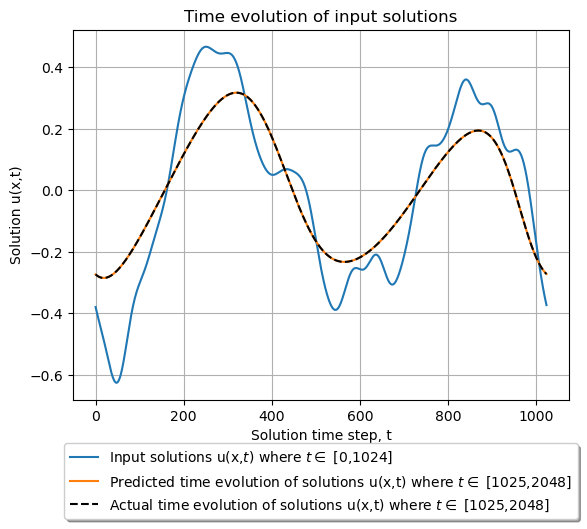

torch.Size([1024, 1])
torch.Size([1024])


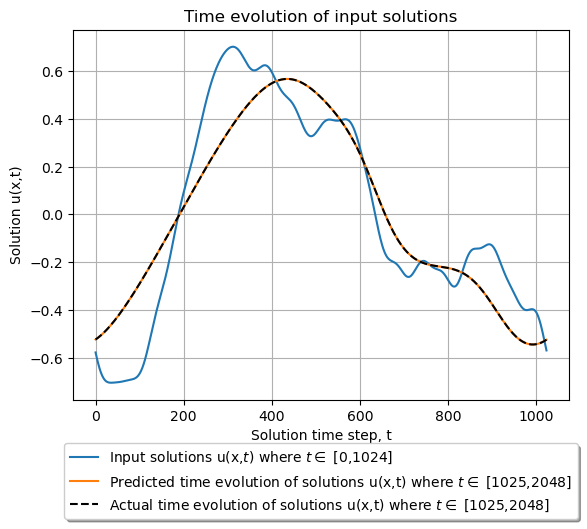

torch.Size([1024, 1])
torch.Size([1024])


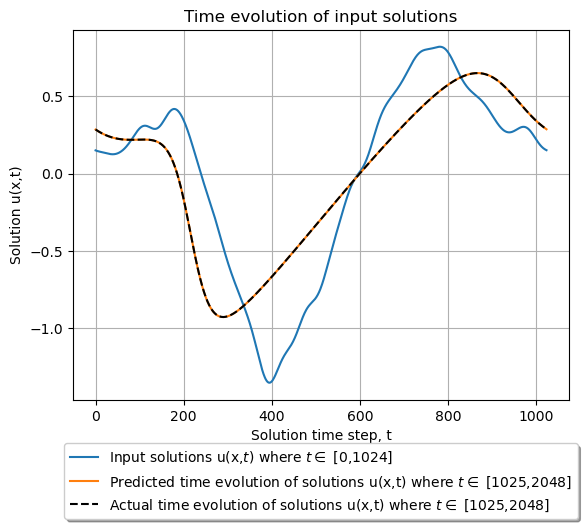

torch.Size([1024, 1])
torch.Size([1024])


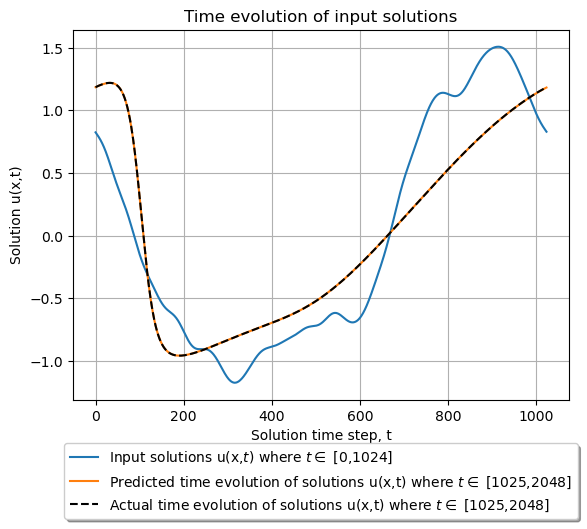

torch.Size([1024, 1])
torch.Size([1024])


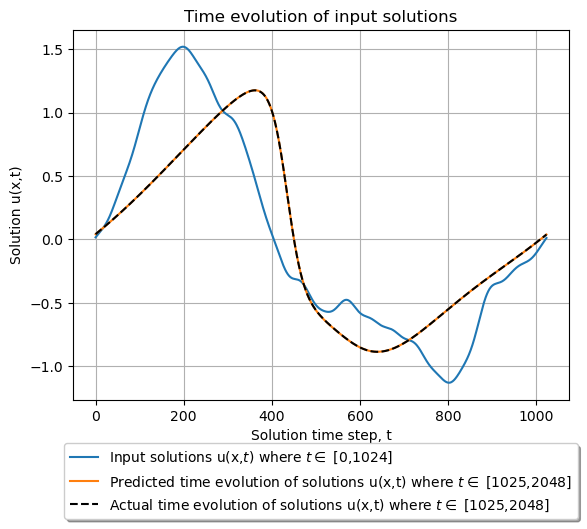

torch.Size([1024, 1])
torch.Size([1024])


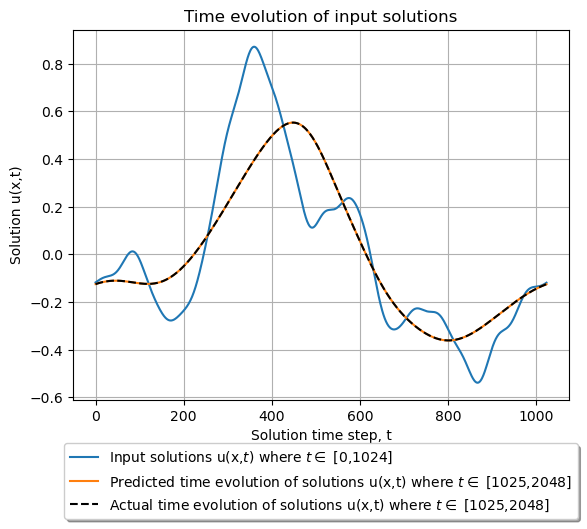

torch.Size([1024, 1])
torch.Size([1024])


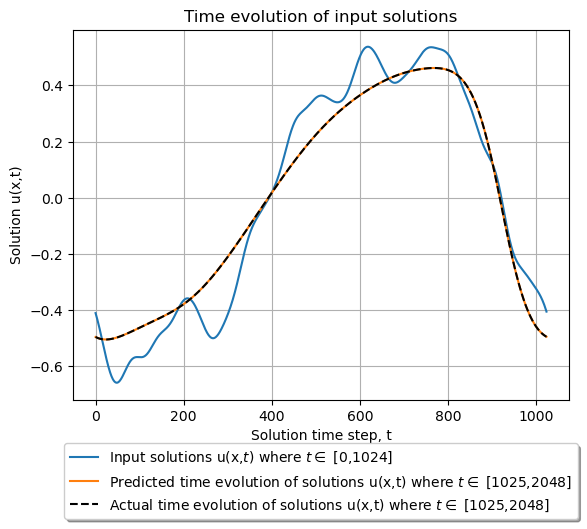

torch.Size([1024, 1])
torch.Size([1024])


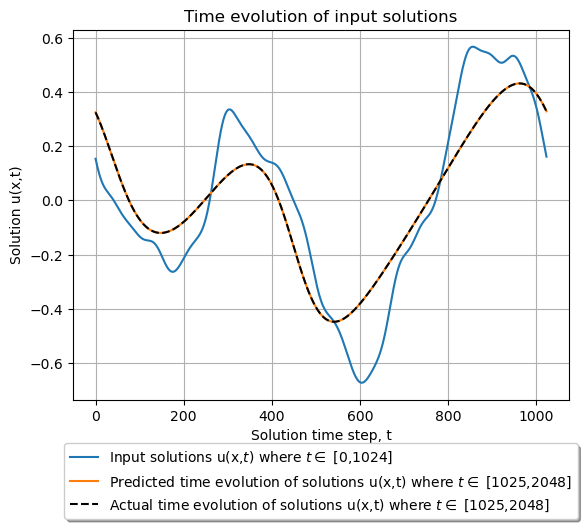

torch.Size([1024, 1])
torch.Size([1024])


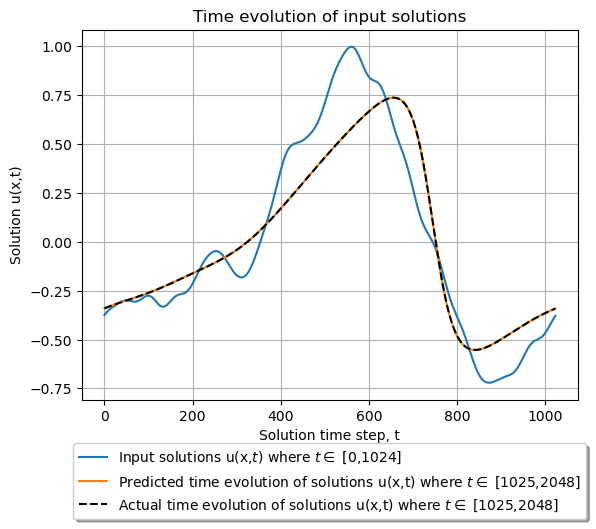

torch.Size([1024, 1])
torch.Size([1024])


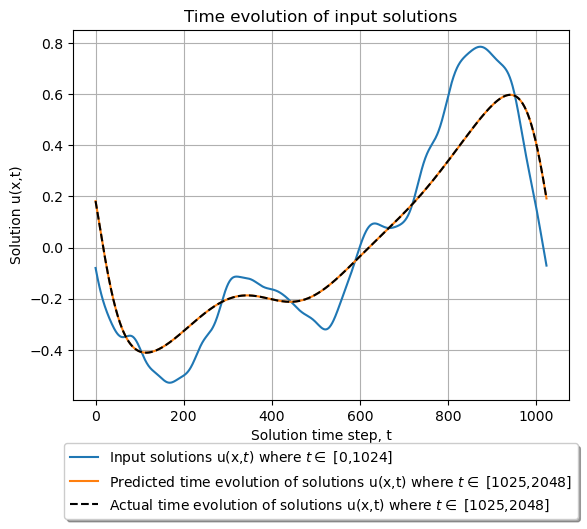

torch.Size([1024, 1])
torch.Size([1024])


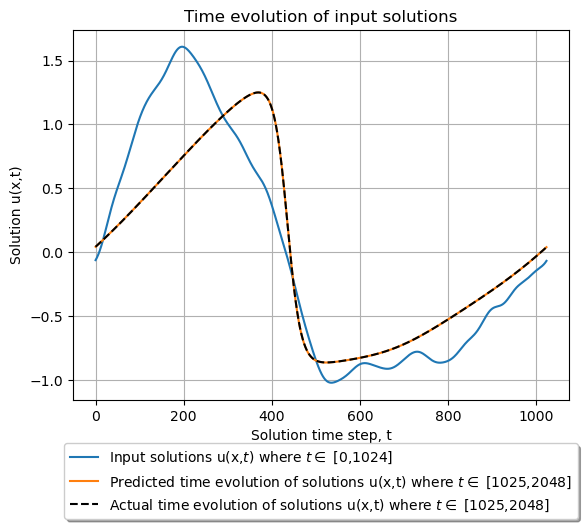

torch.Size([1024, 1])
torch.Size([1024])


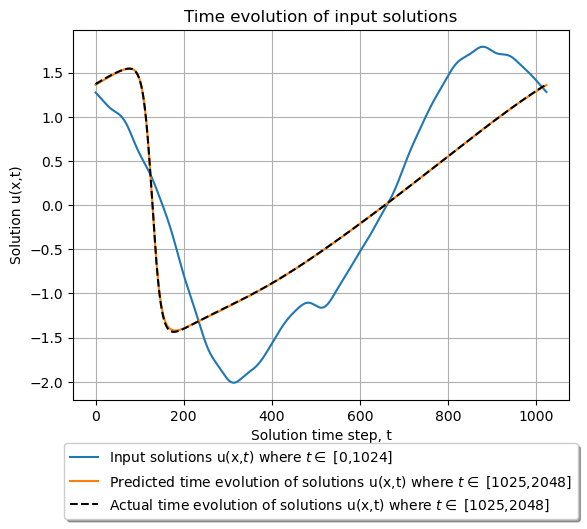

torch.Size([1024, 1])
torch.Size([1024])


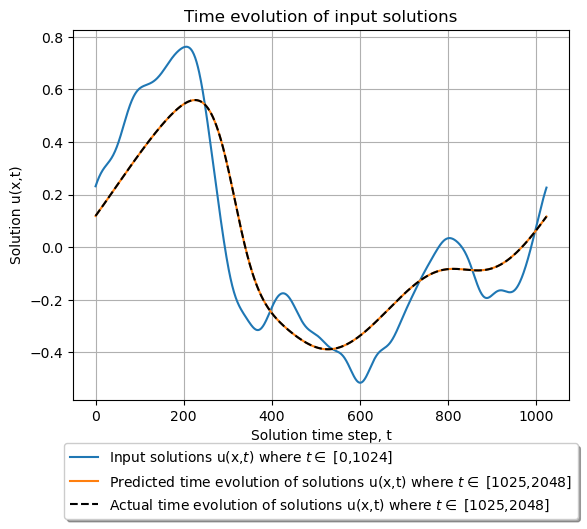

torch.Size([1024, 1])
torch.Size([1024])


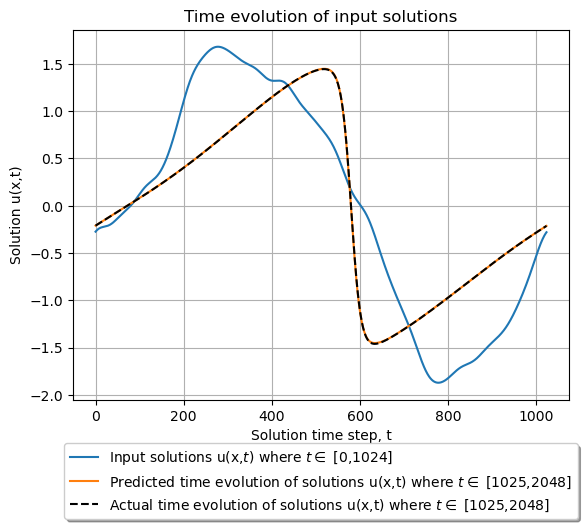

torch.Size([1024, 1])
torch.Size([1024])


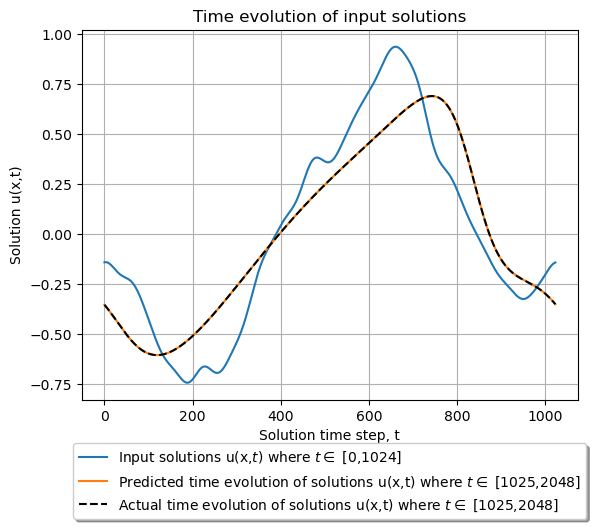

torch.Size([1024, 1])
torch.Size([1024])


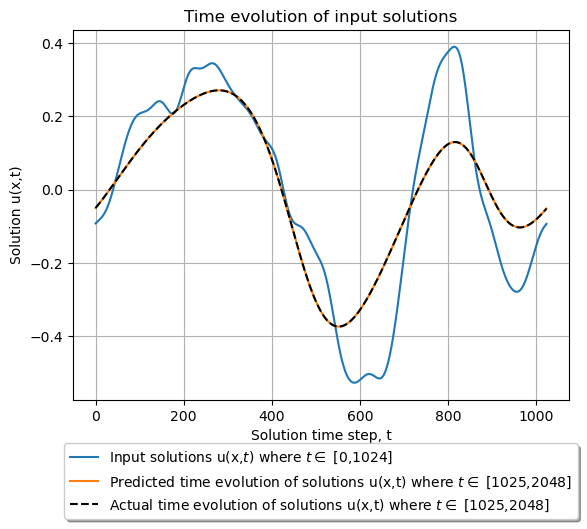

torch.Size([1024, 1])
torch.Size([1024])


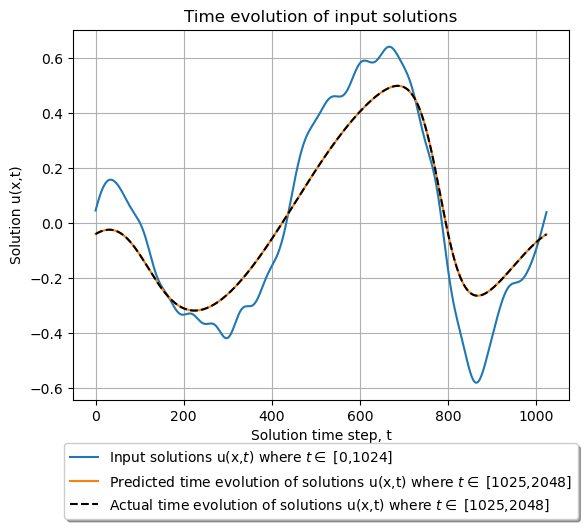

torch.Size([1024, 1])
torch.Size([1024])


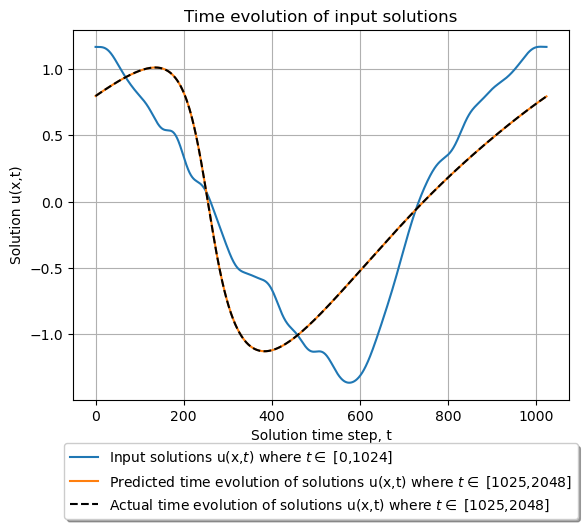

torch.Size([1024, 1])
torch.Size([1024])


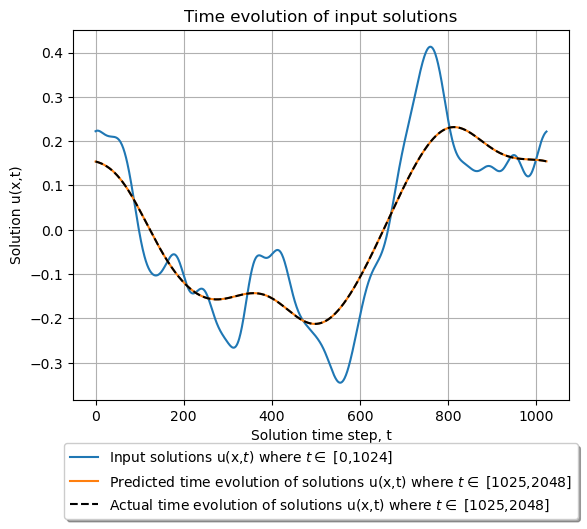

torch.Size([1024, 1])
torch.Size([1024])


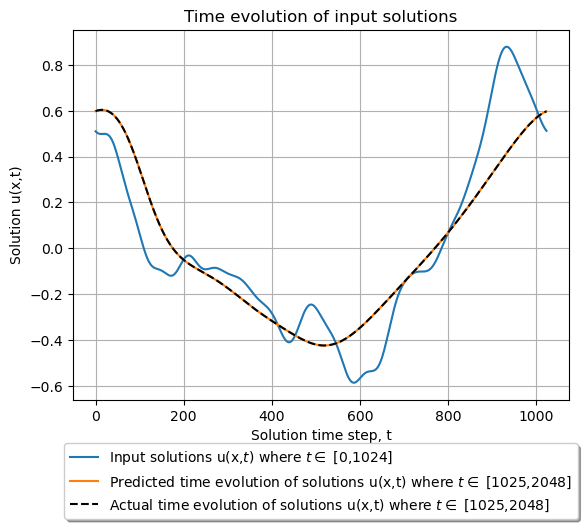

torch.Size([1024, 1])
torch.Size([1024])


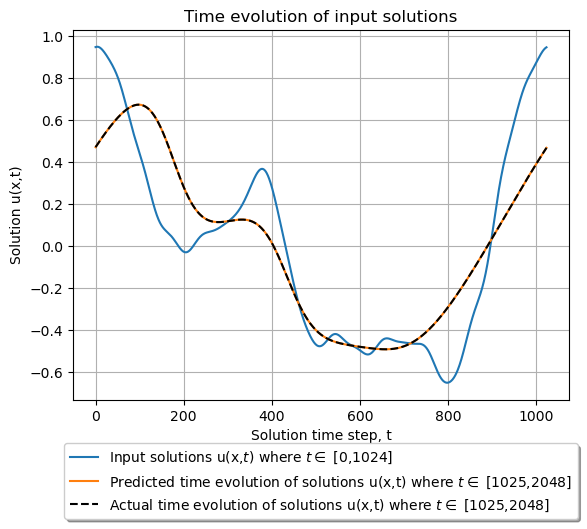

torch.Size([1024, 1])
torch.Size([1024])


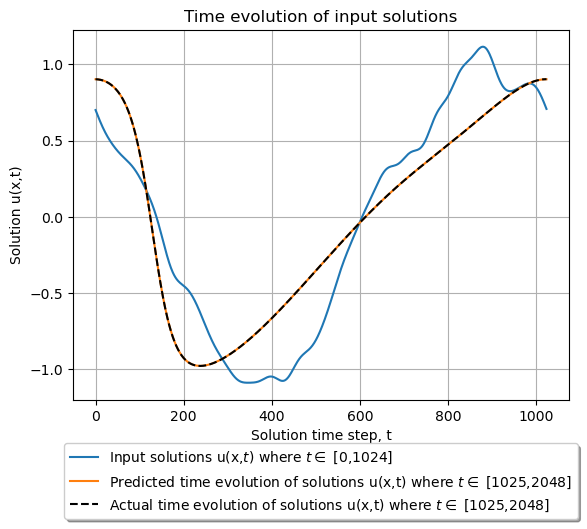

torch.Size([1024, 1])
torch.Size([1024])


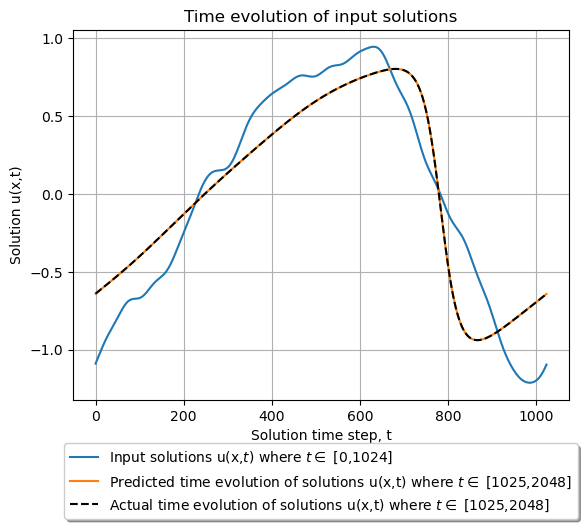

torch.Size([1024, 1])
torch.Size([1024])


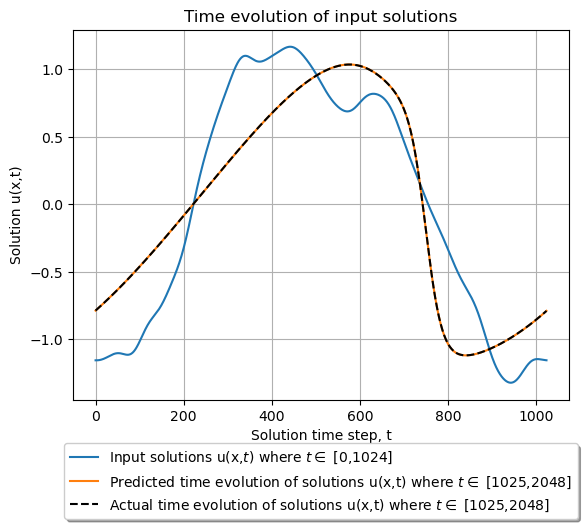

torch.Size([1024, 1])
torch.Size([1024])


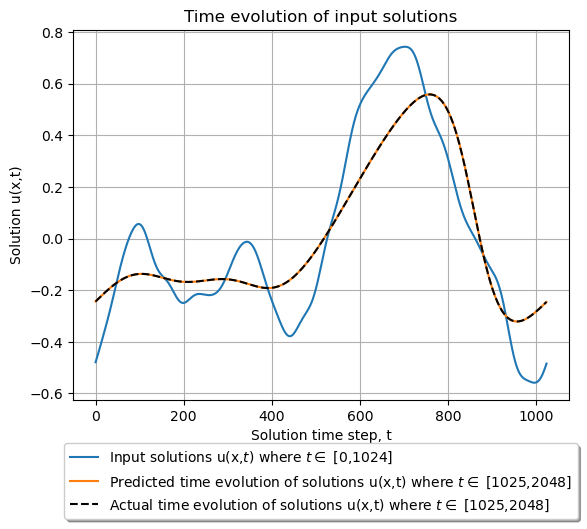

torch.Size([1024, 1])
torch.Size([1024])


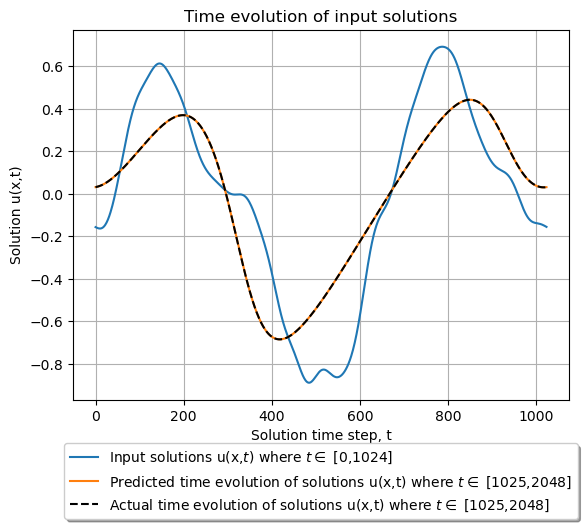

torch.Size([1024, 1])
torch.Size([1024])


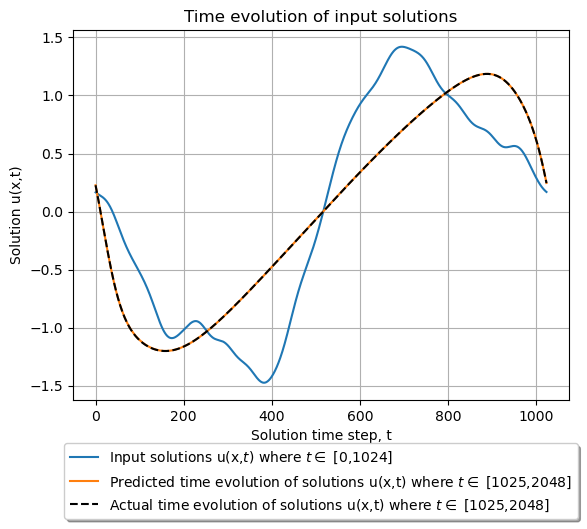

torch.Size([1024, 1])
torch.Size([1024])


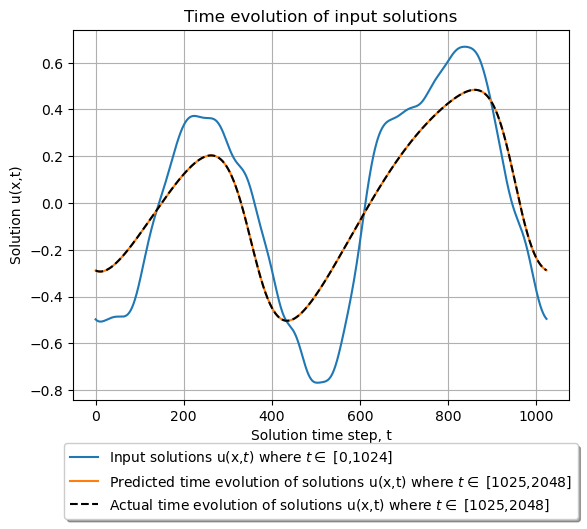

torch.Size([1024, 1])
torch.Size([1024])


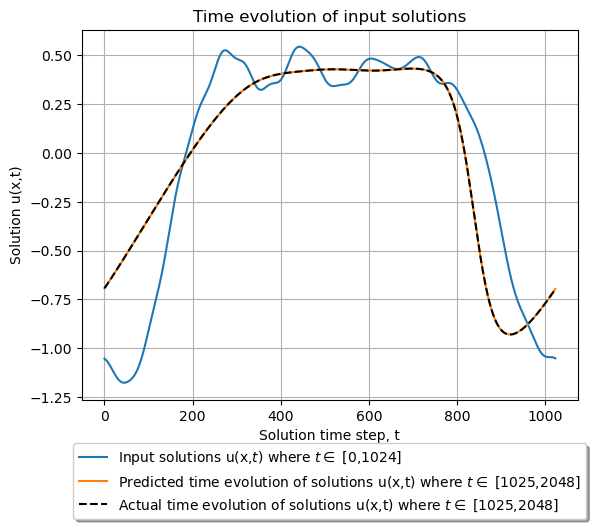

torch.Size([1024, 1])
torch.Size([1024])


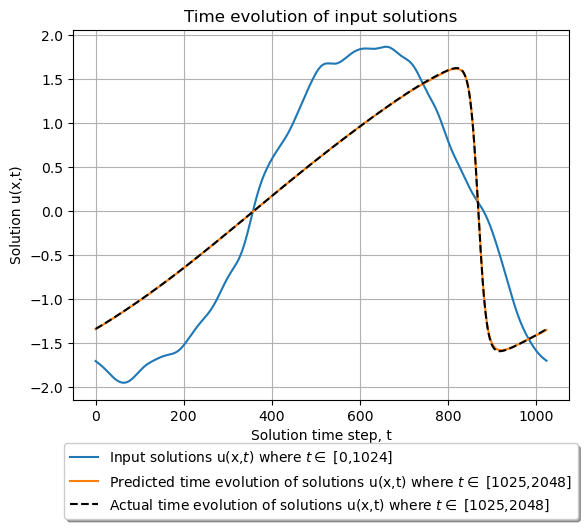

torch.Size([1024, 1])
torch.Size([1024])


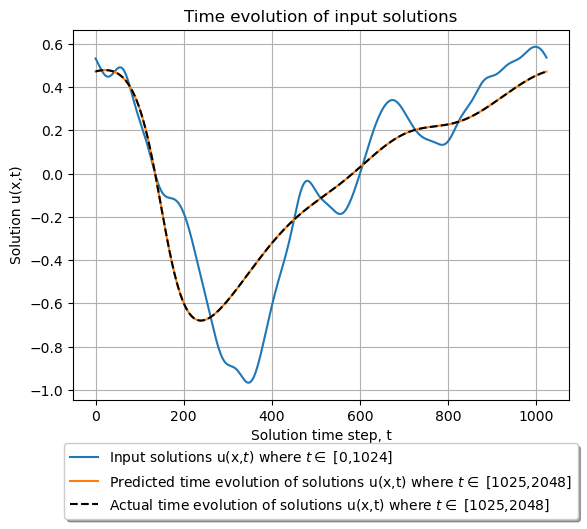

torch.Size([1024, 1])
torch.Size([1024])


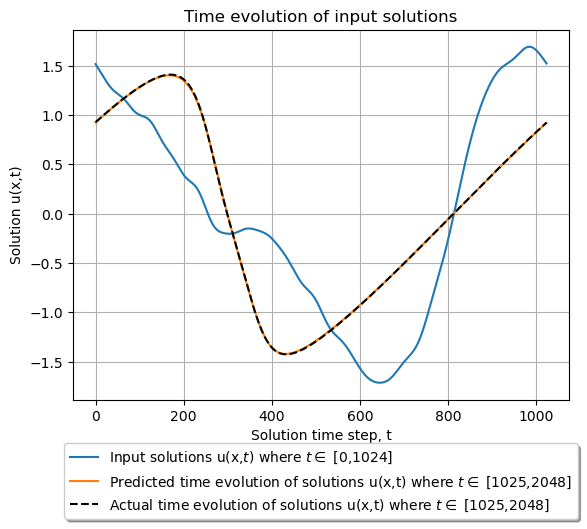

torch.Size([1024, 1])
torch.Size([1024])


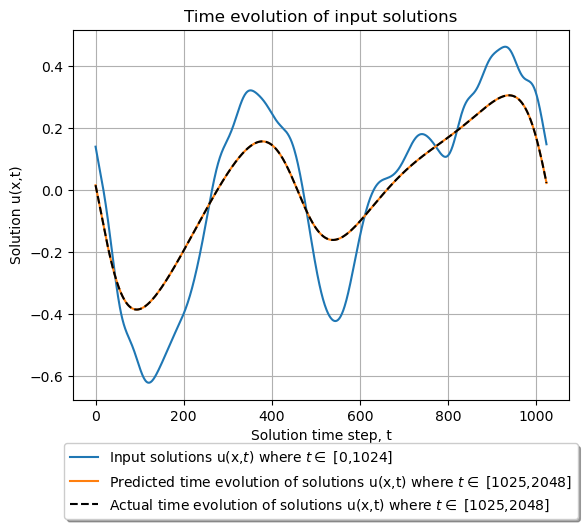

torch.Size([1024, 1])
torch.Size([1024])


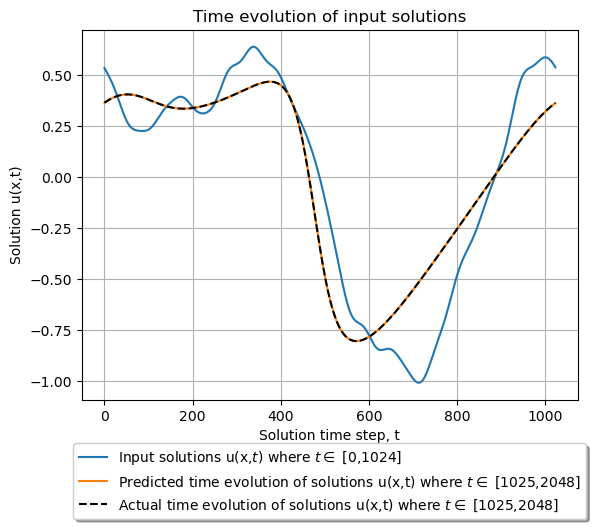

torch.Size([1024, 1])
torch.Size([1024])


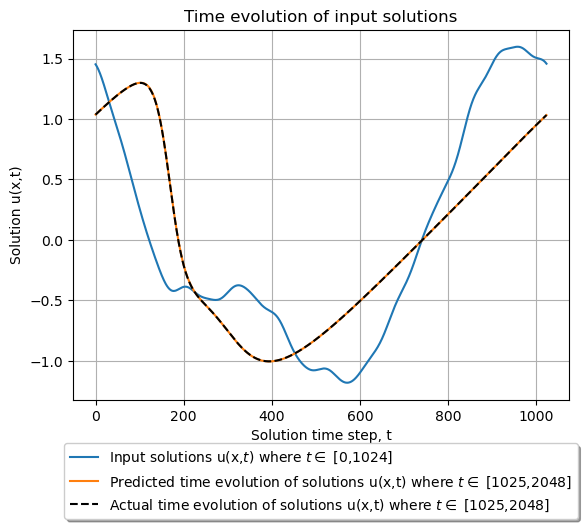

In [9]:

# Model class must be defined somewhere
model = torch.load('model/ns_fourier_burgers')
model.eval()
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        # x, y = x.cuda(), y.cuda()
        x, y = x.cpu(), y.cpu()

        out = model(x).view(-1)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        #print(index, test_l2)
        index = index + 1

index = 0
for x, y in test_loader:

    # Shapes is 1024 inputs (x) and 1024 outputs (y)
    print(x[0].shape)
    print(y[0].shape)

    # Create plots with pre-defined labels.    
    fig, ax = plt.subplots()
    ax.plot(x[0], label='Input solutions u(x,$t$) where $t \in$ [0,1024]')
    ax.plot(pred[index], label='Predicted time evolution of solutions u(x,t) where $t \in$ [1025,2048]')
    ax.plot(y[0], 'k--', label='Actual time evolution of solutions u(x,t) where $t \in$ [1025,2048]')
    index += 1
    legend = ax.legend(loc='upper center', shadow=True, bbox_to_anchor=(0.5, -0.1))
    ax.set_xlabel("Solution time step, t")
    ax.set_ylabel("Solution u(x,t)")
    ax.set_title("Time evolution of input solutions")
    ax.grid()
    
    # Put a nicer background color on the legend.
    # legend.get_frame().set_facecolor('C0')
    plt.show()

# scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})